### Import Libraries

In [1]:
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras import backend as K
from keras.metrics import top_k_categorical_accuracy
import os

Using TensorFlow backend.


In [2]:
# def set_keras_backend(backend):

#     if K.backend() != backend:
#         os.environ['KERAS_BACKEND'] = backend
#         reload(K)
#         assert K.backend() == backend

# set_keras_backend("theano")
K.set_image_data_format('channels_first')
print(K.backend(), K.image_data_format())

tensorflow channels_first


### Define Parameters

In [3]:
batch_size = 128 #128
samples_per_epoch = 10
num_classes = 5
epochs = 40
class_names = ["voip", "video", "file transfer", "chat", "browsing"]

# input hist dimensions
height, width = 1500, 1500
input_shape = (1, height, width)
MODEL_NAME = "overlap_multiclass_reg_non_bn"
PATH_PREFIX = "D:/TS/Internet Traffic Classification/datasets/overlap_multiclass_reg/overlap_multiclass_"

### Import Train and Validation Data

In [4]:
x_train = np.load(PATH_PREFIX + "reg_x_train.npy")
y_train_true = np.load(PATH_PREFIX + "reg_y_train.npy")
x_val = np.load(PATH_PREFIX + "reg_x_val.npy")
y_val_true = np.load(PATH_PREFIX + "reg_y_val.npy")

print(x_train.shape, y_train_true.shape)
print(x_val.shape, y_val_true.shape)

(3350, 1, 1500, 1500) (3350,)
(314, 1, 1500, 1500) (314,)


### Shuffle Data

In [5]:
def shuffle_data(x, y):
    s = np.arange(x.shape[0])
    np.random.shuffle(s)
    x = x[s]
    y = y[s]
    print (x.shape, y.shape)
    return x, y

x_train, y_train_true = shuffle_data(x_train, y_train_true)

print(y_train_true[0:10])

(3350, 1, 1500, 1500) (3350,)
[ 2.  4.  4.  3.  3.  1.  1.  3.  4.  1.]


### convert class vectors to binary class matrices

In [6]:
y_train = np_utils.to_categorical(y_train_true, num_classes)
y_val = np_utils.to_categorical(y_val_true, num_classes)
print(y_train[0:10])
print (y_val[0:10])
print(y_train.shape, y_val.shape)

[[ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.]]
[[ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]]
(3350, 5) (314, 5)


### Define and Compile model

In [7]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec))

def top_2_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2) 

from keras.layers.core import Activation

model = Sequential()
# model.add(BatchNormalization(input_shape=input_shape, axis=-1, momentum=0.99, epsilon=0.001)) ############################
model.add(Conv2D(10, kernel_size=(10, 10),strides=5,padding="same", input_shape=input_shape))
convout1 = Activation('relu')
model.add(convout1)
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)
model.add(Conv2D(20, (10, 10),strides=5,padding="same"))  #################################################
convout2 = Activation('relu')
model.add(convout2)
print(model.output_shape)
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)
model.add(Flatten())
print(model.output_shape)
model.add(Dense(64, activation='relu'))
print(model.output_shape)
model.add(Dropout(0.5))
print(model.output_shape)
model.add(Dense(num_classes, activation='softmax'))
print(model.output_shape)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_2_categorical_accuracy, f1_score, precision, recall])

(None, 10, 300, 300)
(None, 10, 150, 150)
(None, 20, 30, 30)
(None, 20, 15, 15)
(None, 4500)
(None, 64)
(None, 64)
(None, 5)


### Define nice_imshow and make_moasic functions

In [8]:
import pylab as pl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None, bar=True):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap,origin='lower')
    if bar:
        cax = divider.append_axes("right", size="5%", pad=0.05)
        pl.colorbar(im, cax=cax)

def plotNNFilter2(data, nrows, ncols, layer_name, cmap=None, bar=True):
    """Wrapper around pl.subplot with color bar"""
    if cmap is None:
        cmap = "gray"
    
    fig, axes = pl.subplots(nrows, ncols,figsize=(5*ncols, 4*nrows))
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(data[:,:,i], interpolation="nearest", cmap=cmap)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.invert_yaxis()

    fig.subplots_adjust(wspace=0.025, hspace=0.05)
    if bar:
        fig.colorbar(im, ax=axes.ravel().tolist())
    
    pl.savefig(MODEL_NAME +  "_plotNNFilter2_" + layer_name, bbox_inches='tight', pad_inches=1)
    pl.show()

def plotNNFilter(data, nrows, ncols, layer_name, cmap=None, bar=True):
    """Wrapper around pl.subplot"""
    if cmap is None:
        cmap = "gray"
    
    pl.figure(figsize=(3*ncols, 3*nrows))
    
    for i in range(nrows*ncols):
        pl.subplot(nrows, ncols, i+1)
        pl.imshow(data[:,:,i], interpolation="nearest", cmap=cmap)
        pl.xticks([])
        pl.yticks([])
        pl.gca().invert_yaxis()
    pl.subplots_adjust(wspace=0.025, hspace=0.05)
    pl.savefig(MODEL_NAME +  "_plotNNFilter_" + layer_name, bbox_inches='tight', pad_inches=1)
    pl.show()
        
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[2]
    imshape = imgs.shape[0:2]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:,:,i]
    return mosaic

def mosaic_imshow(imgs, nrows, ncols, cmap=None, border=1, layer_name="convout"):
    pl.figure(figsize=(3*ncols, 3*nrows))
#     pl.suptitle('convout2')
    nice_imshow(pl.gca(), make_mosaic(imgs, nrows, ncols, border=border), cmap=cmap)
    pl.savefig(MODEL_NAME +  "_mosaic_imshow_" + layer_name, bbox_inches='tight', pad_inches=1)
    pl.show()

# pl.imshow(make_mosaic(np.random.random((10, 10, 9)), 3, 3, border=1))
# pl.show()

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 5 4]]
1.0


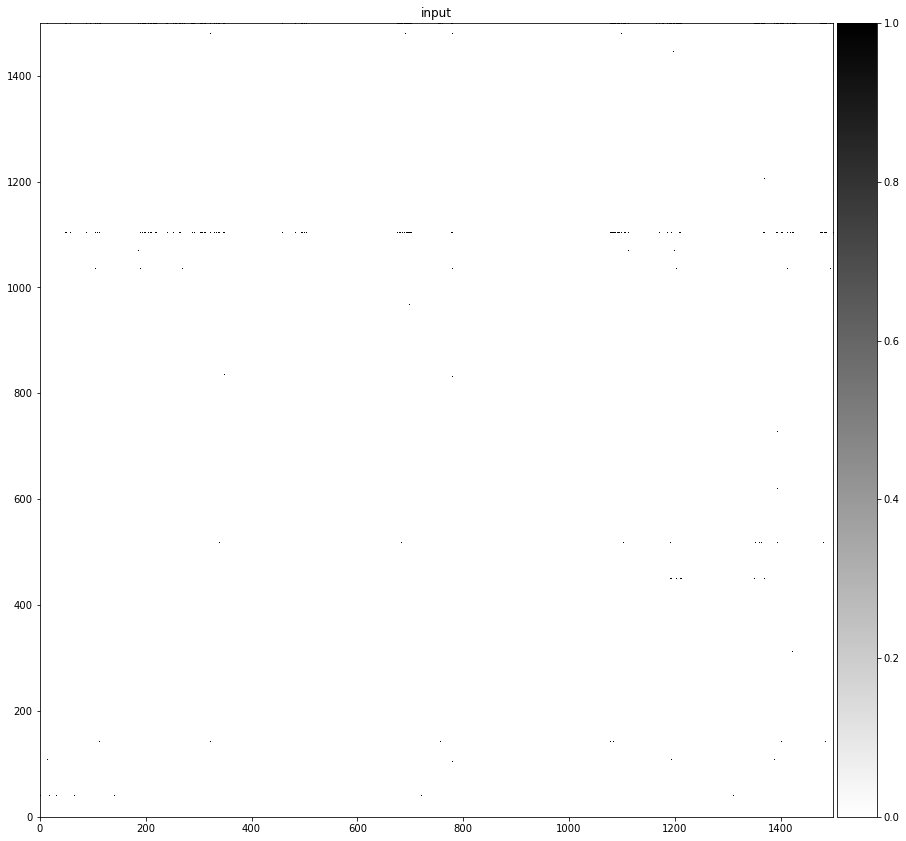

convout1_before output shape :  (10, 300, 300)
convout1_before output shape :  (300, 300, 10)


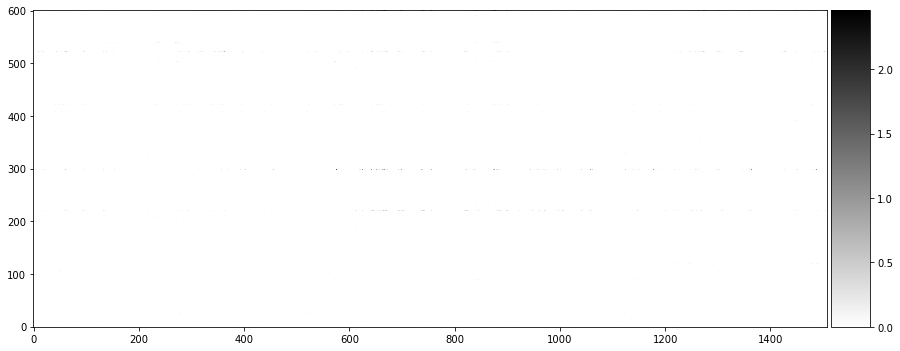

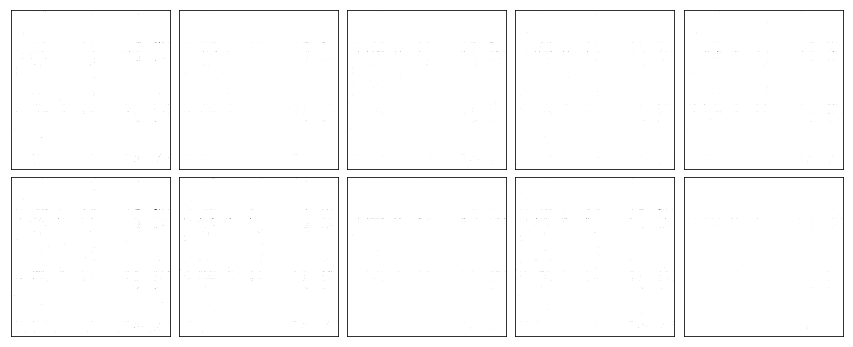

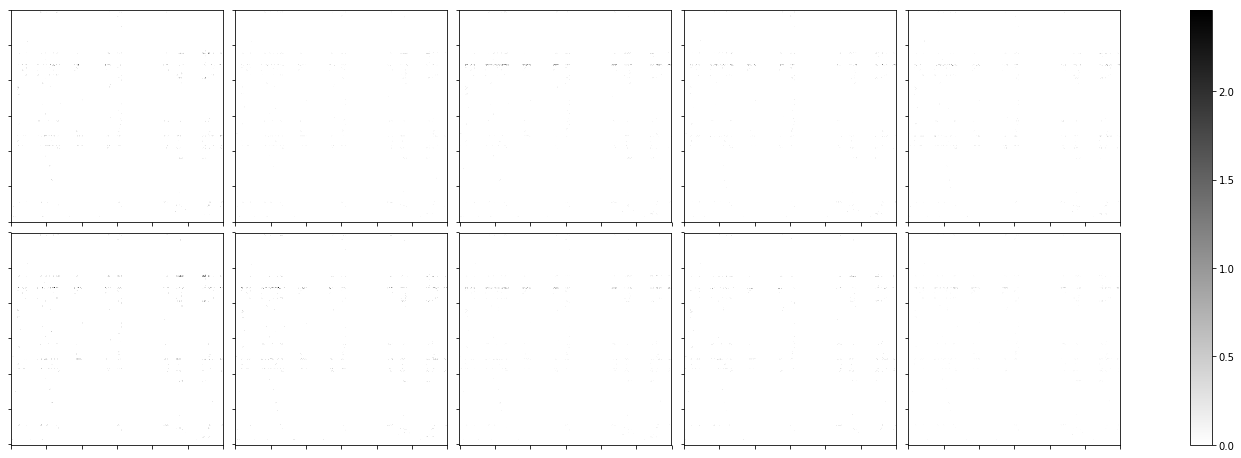

convout2_before output shape :  (20, 30, 30)
convout2_before output shape :  (30, 30, 20)


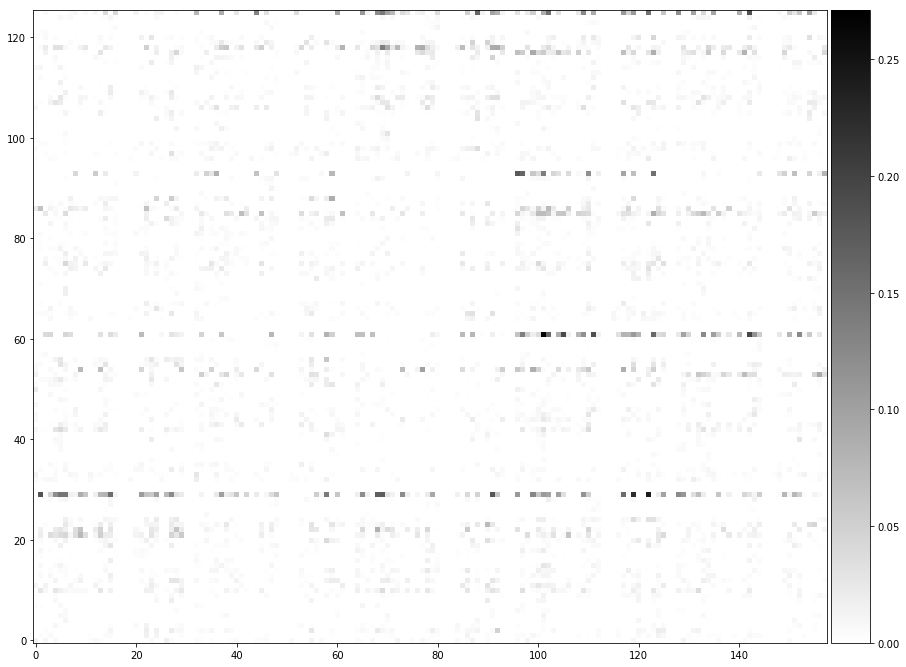

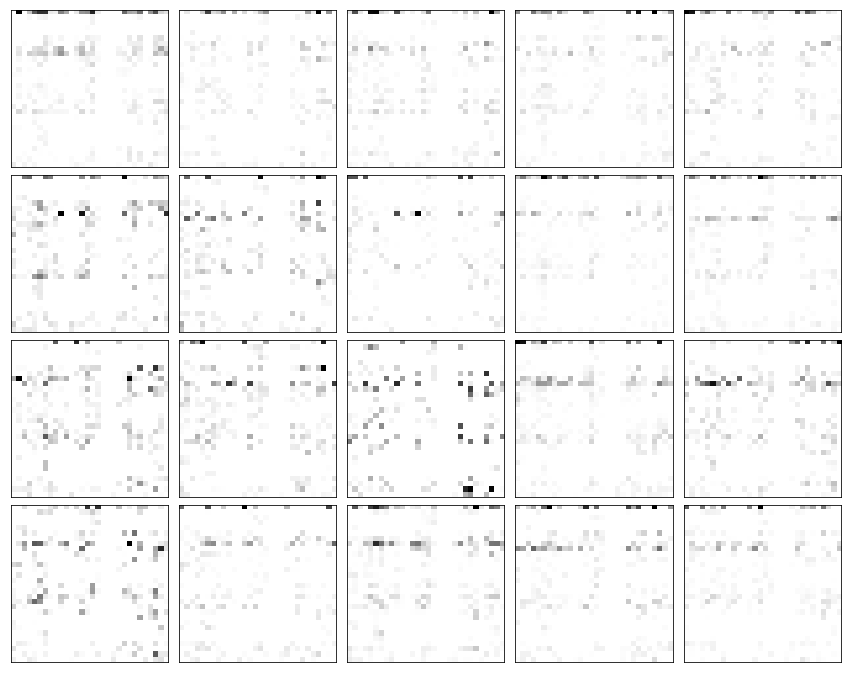

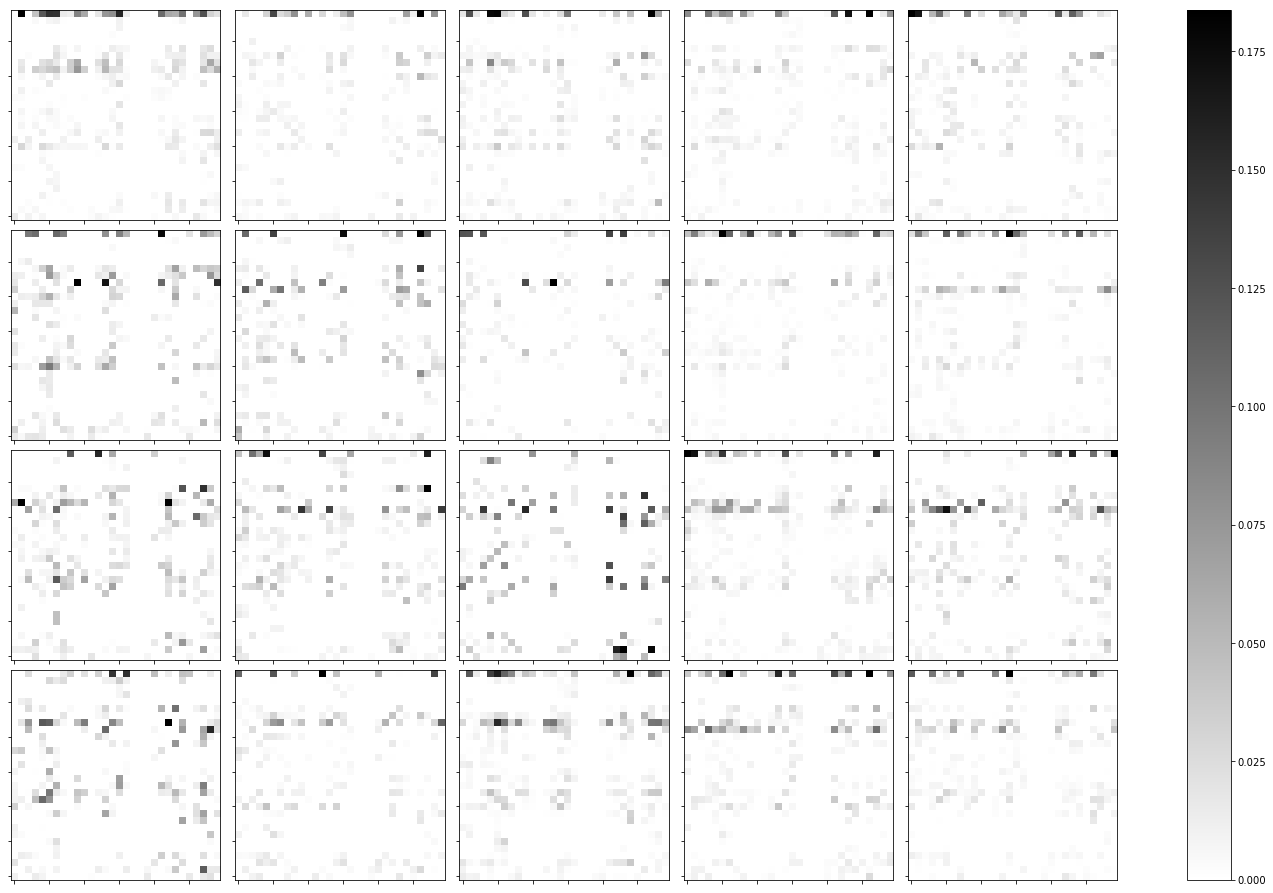

In [13]:
# Visualize the first layer of convolutions on an input image
i = 35
X = x_train[i][0]
print(X)
print(y_train_true[i])
pl.figure(figsize=(15, 15))
pl.title('input')
nice_imshow(pl.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.binary)
pl.savefig(MODEL_NAME +  "_input", bbox_inches='tight', pad_inches=1)
pl.show()

# Visualize convolution result (after activation)
def get_layer_output(layer, input_img, layer_name):
    convout_f = K.function(model.inputs, [layer.output])
    C = convout_f([input_img])
    C = np.squeeze(C)
    print(layer_name + " output shape : ", C.shape)
    C = np.transpose(C)
    C = np.swapaxes(C,0,1)
    print(layer_name + " output shape : ", C.shape)
    return C
    

C1 = get_layer_output(convout1, x_train[i:i+1], layer_name="convout1_before")
mosaic_imshow(C1, 2, 5, cmap=cm.binary, border=2, layer_name="convout1_before")
plotNNFilter(C1, 2, 5, cmap=cm.binary, layer_name="convout1_before")
plotNNFilter2(C1, 2, 5, cmap=cm.binary, layer_name="convout1_before")

C2 = get_layer_output(convout2, x_train[i:i+1], layer_name="convout2_before")
mosaic_imshow(C2, 4, 5, cmap=cm.binary, border=2, layer_name="convout2_before")
plotNNFilter(C2, 4, 5, cmap=cm.binary, layer_name="convout2_before")
plotNNFilter2(C2, 4, 5, cmap=cm.binary, layer_name="convout2_before")

W1 shape :  (10, 10, 10)


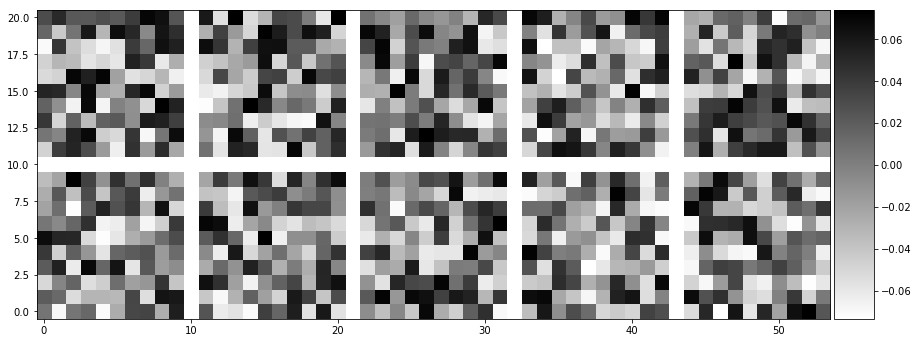

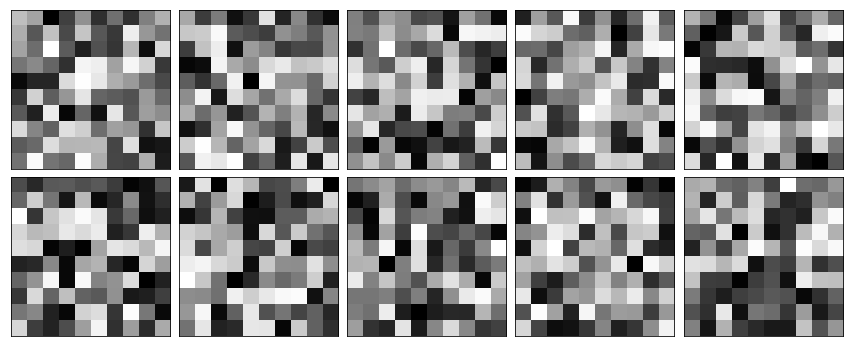

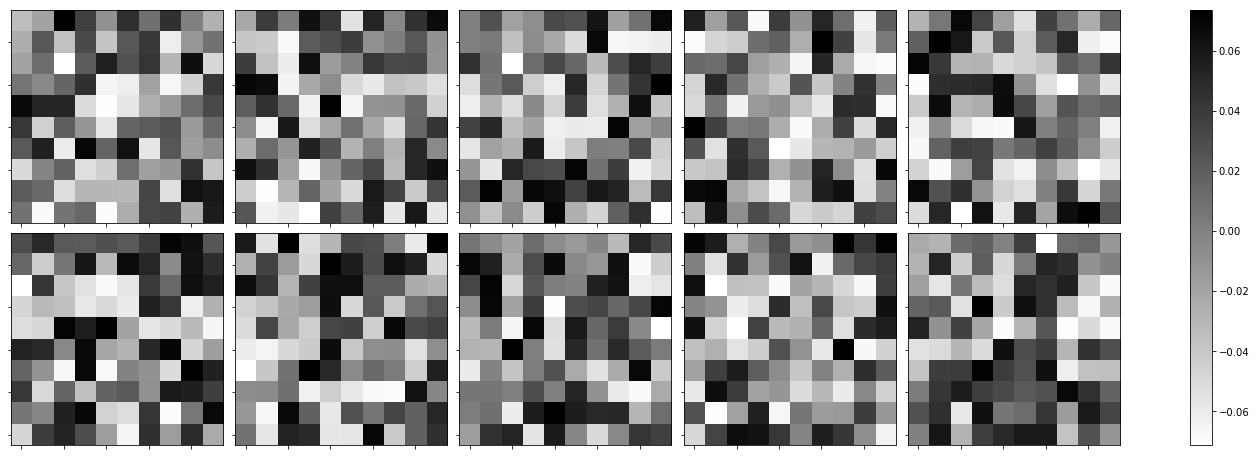

W2 shape :  (10, 10, 20)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:861: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


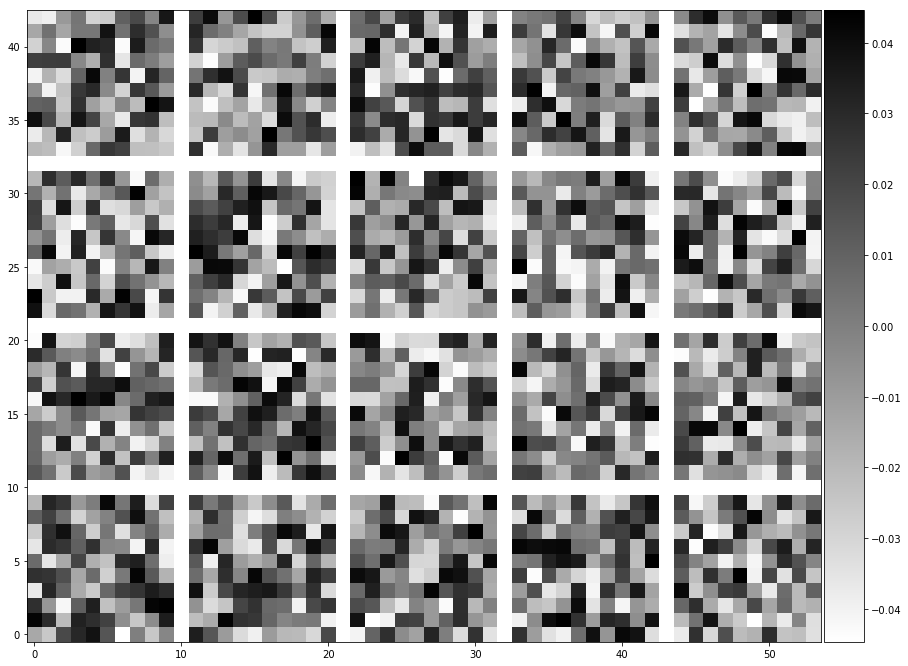

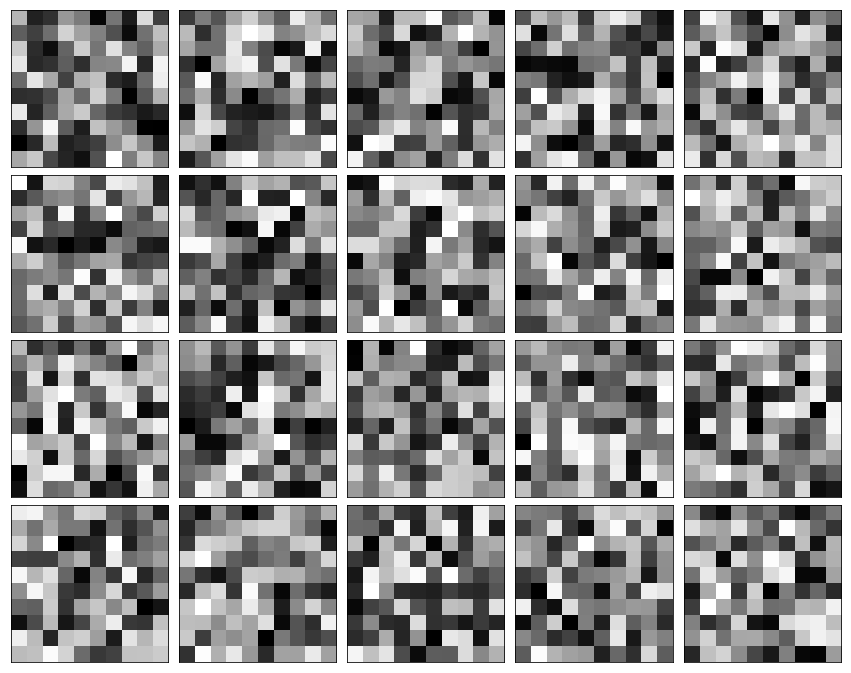

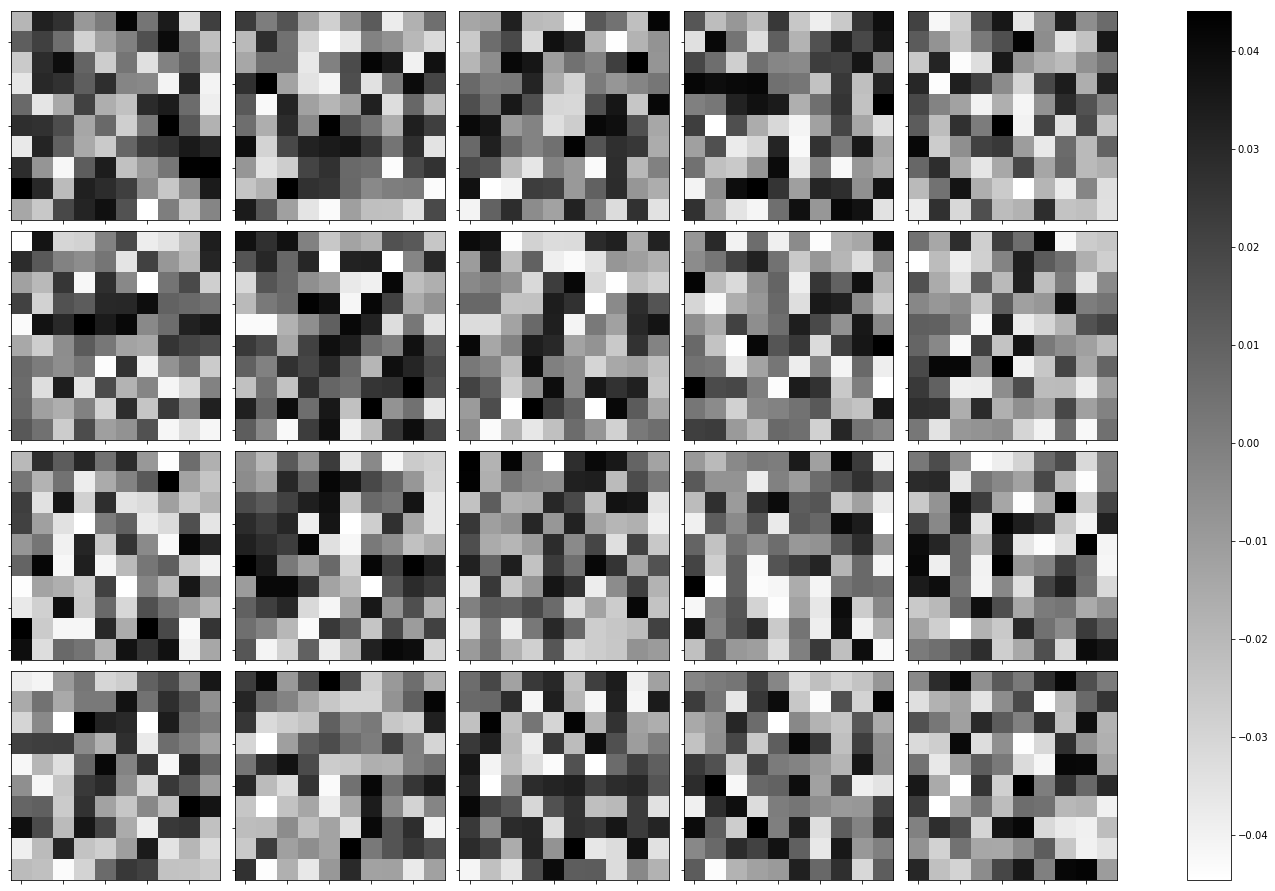

In [14]:
# Visualize weights
W1 = model.layers[0].get_weights()[0]
W1 = np.squeeze(W1)
# W1 = np.asarray(W1)
print("W1 shape : ", W1.shape)

mosaic_imshow(W1, 2, 5, cmap=cm.binary, border=1, layer_name="conv1_weights_before")
plotNNFilter(W1, 2, 5, cmap=cm.binary, layer_name="conv1_weights_before")
plotNNFilter2(W1, 2, 5, cmap=cm.binary, layer_name="conv1_weights_before")

# Visualize weights
W2 = model.layers[3].get_weights()[0][:,:,0,:]
W2 = np.asarray(W2)
print("W2 shape : ", W2.shape)

mosaic_imshow(W2, 4, 5, cmap=cm.binary, border=1, layer_name="conv2_weights_before")
plotNNFilter(W2, 4, 5, cmap=cm.binary, layer_name="conv2_weights_before")
plotNNFilter2(W2, 4, 5, cmap=cm.binary, layer_name="conv2_weights_before")


### Fit model on training data

In [15]:
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=1, write_grads=True, write_graph=True,
                          write_images=True, batch_size=batch_size)
checkpointer_loss = ModelCheckpoint(filepath= MODEL_NAME + '_loss.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
checkpointer_acc = ModelCheckpoint(monitor='val_acc', filepath= MODEL_NAME + '_acc.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
tensorboard.set_model(model)

def generator(features, labels, batch_size):
    index = 0
    while True:
        index += batch_size
        if index >= len(features):
            batch_features = np.append(features[index-batch_size:len(features)], features[0:index-len(features)], axis=0)
            batch_labels = np.append(labels[index-batch_size:len(features)], labels[0:index-len(features)], axis=0)
            index -= len(features)
            yield batch_features, batch_labels
        else:
            yield features[index-batch_size:index], labels[index-batch_size:index]

history = model.fit_generator(generator(x_train, y_train, batch_size),
          epochs=epochs,
          samples_per_epoch=samples_per_epoch,
          verbose=1,
          callbacks=[tensorboard,checkpointer_loss,checkpointer_acc],
          validation_data=(x_val, y_val))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=40, verbose=1, callbacks=[<keras.ca..., validation_data=(array([[[..., steps_per_epoch=10)`


Epoch 1/40
 9/10 [==========================>...] - ETA: 29s - loss: 1.2952 - acc: 0.4271 - top_2_categorical_accuracy: 0.6085 - f1_score: nan - precision: 0.8089 - recall: 0.1649Epoch 00000: val_loss improved from inf to 1.00429, saving model to overlap_multiclass_reg_non_bn_loss.hdf5
Epoch 00000: val_acc improved from -inf to 0.56369, saving model to overlap_multiclass_reg_non_bn_acc.hdf5
10/10 [==============================] - 390s - loss: 1.2589 - acc: 0.4516 - top_2_categorical_accuracy: 0.6250 - f1_score: nan - precision: 0.8199 - recall: 0.1930 - val_loss: 1.0043 - val_acc: 0.5637 - val_top_2_categorical_accuracy: 0.6688 - val_f1_score: 0.4889 - val_precision: 0.9526 - val_recall: 0.4204
Epoch 2/40
 9/10 [==========================>...] - ETA: 29s - loss: 0.8743 - acc: 0.6832 - top_2_categorical_accuracy: 0.7934 - f1_score: 0.6471 - precision: 0.9414 - recall: 0.4939Epoch 00001: val_loss improved from 1.00429 to 0.79898, saving model to overlap_multiclass_reg_non_bn_loss.hdf5
E

 9/10 [==========================>...] - ETA: 28s - loss: 0.3569 - acc: 0.8464 - top_2_categorical_accuracy: 0.9679 - f1_score: 0.8433 - precision: 0.8726 - recall: 0.8160Epoch 00012: val_loss did not improve
Epoch 00012: val_acc did not improve
10/10 [==============================] - 388s - loss: 0.3565 - acc: 0.8469 - top_2_categorical_accuracy: 0.9680 - f1_score: 0.8426 - precision: 0.8755 - recall: 0.8125 - val_loss: 0.3411 - val_acc: 0.8280 - val_top_2_categorical_accuracy: 0.9936 - val_f1_score: 0.8011 - val_precision: 0.8626 - val_recall: 0.7611
Epoch 14/40
 9/10 [==========================>...] - ETA: 29s - loss: 0.3400 - acc: 0.8663 - top_2_categorical_accuracy: 0.9774 - f1_score: 0.8487 - precision: 0.9114 - recall: 0.7943Epoch 00013: val_loss did not improve
Epoch 00013: val_acc did not improve
10/10 [==============================] - 390s - loss: 0.3349 - acc: 0.8688 - top_2_categorical_accuracy: 0.9773 - f1_score: 0.8521 - precision: 0.9118 - recall: 0.8000 - val_loss: 0.

10/10 [==============================] - 387s - loss: 0.2395 - acc: 0.9039 - top_2_categorical_accuracy: 0.9867 - f1_score: 0.9058 - precision: 0.9224 - recall: 0.8898 - val_loss: 0.3220 - val_acc: 0.8344 - val_top_2_categorical_accuracy: 0.9936 - val_f1_score: 0.8328 - val_precision: 0.8379 - val_recall: 0.8280
Epoch 27/40
 9/10 [==========================>...] - ETA: 29s - loss: 0.2223 - acc: 0.9132 - top_2_categorical_accuracy: 0.9913 - f1_score: 0.9088 - precision: 0.9261 - recall: 0.8924Epoch 00026: val_loss did not improve
Epoch 00026: val_acc did not improve
10/10 [==============================] - 393s - loss: 0.2205 - acc: 0.9117 - top_2_categorical_accuracy: 0.9914 - f1_score: 0.9071 - precision: 0.9252 - recall: 0.8898 - val_loss: 0.3141 - val_acc: 0.8408 - val_top_2_categorical_accuracy: 0.9936 - val_f1_score: 0.8335 - val_precision: 0.8429 - val_recall: 0.8248
Epoch 28/40
 9/10 [==========================>...] - ETA: 29s - loss: 0.2186 - acc: 0.9080 - top_2_categorical_acc

10/10 [==============================] - 394s - loss: 0.1728 - acc: 0.9367 - top_2_categorical_accuracy: 0.9961 - f1_score: 0.9376 - precision: 0.9417 - recall: 0.9336 - val_loss: 0.3367 - val_acc: 0.8471 - val_top_2_categorical_accuracy: 0.9936 - val_f1_score: 0.8460 - val_precision: 0.8481 - val_recall: 0.8439


### Plot history accuracy

dict_keys(['val_loss', 'val_acc', 'val_top_2_categorical_accuracy', 'val_f1_score', 'val_precision', 'val_recall', 'loss', 'acc', 'top_2_categorical_accuracy', 'f1_score', 'precision', 'recall'])


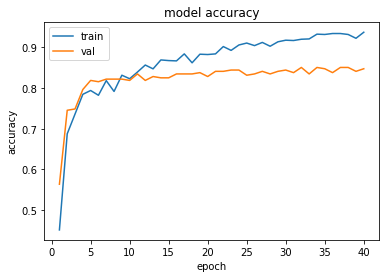

In [16]:
import matplotlib.pyplot as plt
import pickle

with open(MODEL_NAME +  "_accuracy.pkl", 'wb') as output:
    pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)

# list all data in history
print(history.history.keys())
x = np.asarray(range(1,epochs + 1))
# summarize history for accuracy
plt.figure()
plt.plot(x, history.history['acc'])
plt.plot(x, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(MODEL_NAME +  " accuracy history", bbox_inches='tight', pad_inches=1)
plt.show()

### Plot Confusion Matrix

In [17]:
y_val_prediction = model.predict_classes(x_val, verbose=1)

314/314 [==============================] - 29s    


In [18]:
print(y_val_prediction[:10])

[4 4 4 4 4 4 4 4 4 4]


Confusion matrix, without normalization
[[59  0  2  0  0]
 [ 0 69  0  0  1]
 [ 0  0 63  0  0]
 [ 0  0  0 14 40]
 [ 0  0  0  5 61]]
Normalized confusion matrix
[[ 0.97  0.    0.03  0.    0.  ]
 [ 0.    0.99  0.    0.    0.01]
 [ 0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.26  0.74]
 [ 0.    0.    0.    0.08  0.92]]


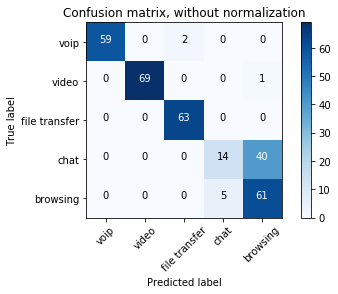

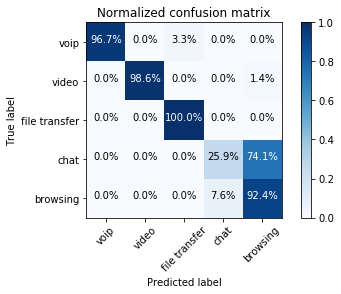

In [19]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(fname, bbox_inches='tight', pad_inches=1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val_true, y_val_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix',
                      fname=MODEL_NAME + "_" + 'Normalized_confusion_matrix')

plt.show()

In [ ]:
def stats(y_true, y_pred):
    correct = sum([1 for i,pred in enumerate(y_pred) if y_true[i][pred]==1])
    print(y_true.shape[0], correct, correct*1.0/len(y_true))
    
    for class_ind in range(y_true.shape[1]):
        total_ind = len([1 for val in y_true if val[class_ind]==1])
        correct_ind = sum([1 for i,pred in enumerate(y_pred) if (pred == class_ind and y_true[i][pred]==1)])
        print(class_ind, total_ind, correct_ind, correct_ind*1.0/total_ind)

stats(y_val, y_val_prediction)
# stats(y_test_vpn, y_test_vpn_prediction)
# stats(y_test_tor, y_test_tor_prediction)
# correct_1 = sum([1 for i,pred in enumerate(y_test_prediction) if (pred == 1 and y_test[i][pred]==1)])
# print correct_1, correct_1*1.0/len([1 for val in y_test if val[1]==1])

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_val_true, y_val_prediction))

             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98        61
        1.0       1.00      0.99      0.99        70
        2.0       0.97      1.00      0.98        63
        3.0       0.74      0.26      0.38        54
        4.0       0.60      0.92      0.73        66

avg / total       0.86      0.85      0.83       314



[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 5 4]]
1.0


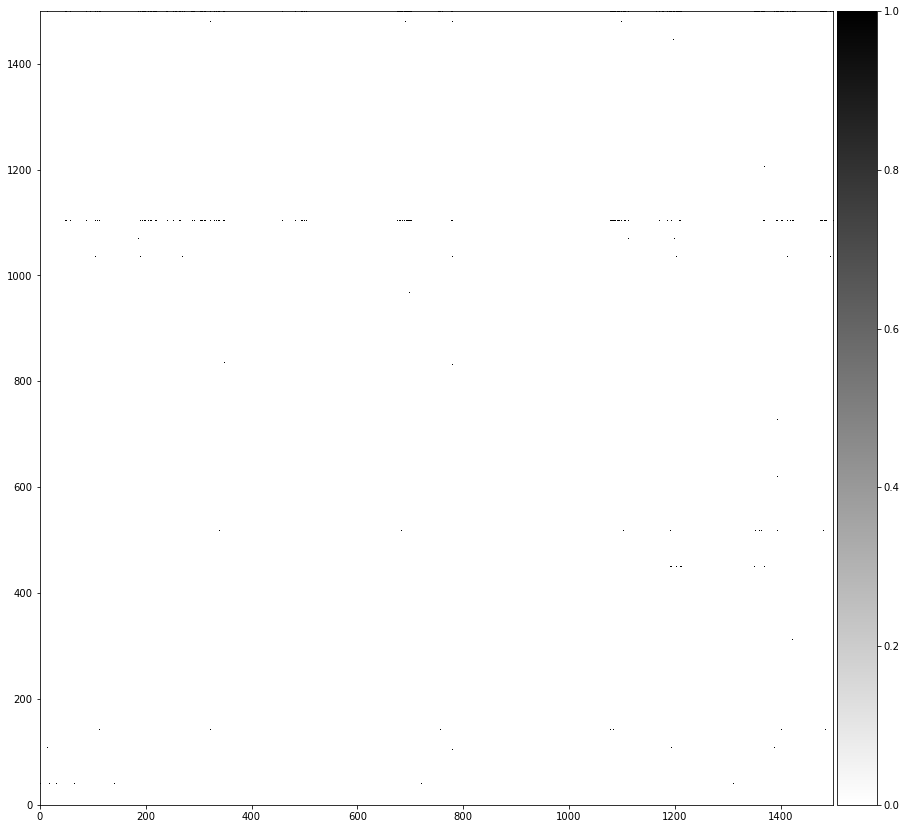

convout1_1 output shape :  (10, 300, 300)
convout1_1 output shape :  (300, 300, 10)


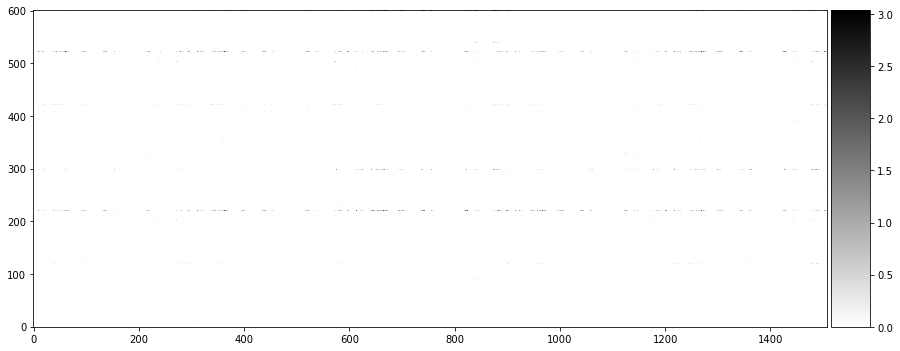

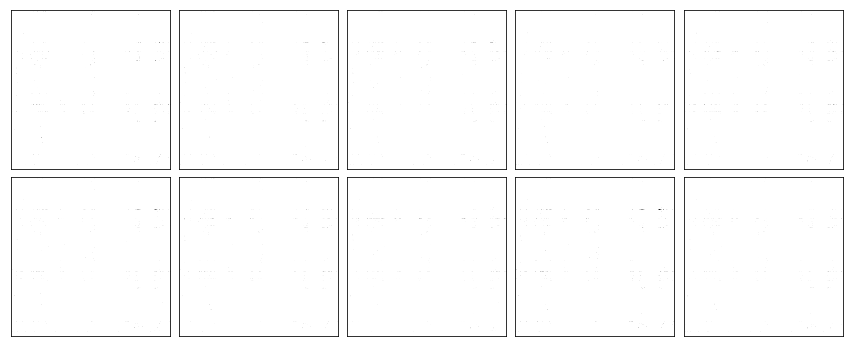

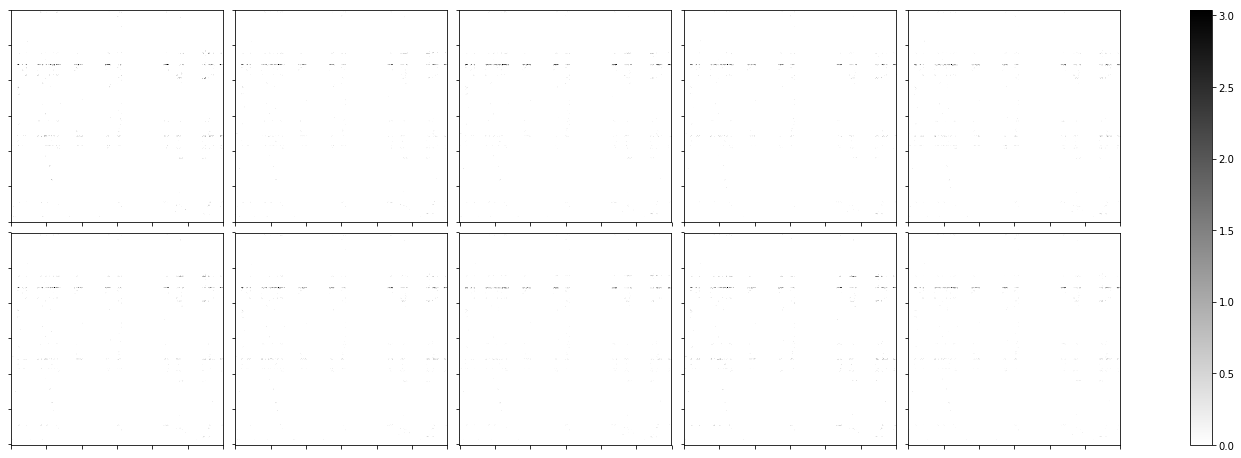

convout2_1 output shape :  (20, 30, 30)
convout2_1 output shape :  (30, 30, 20)


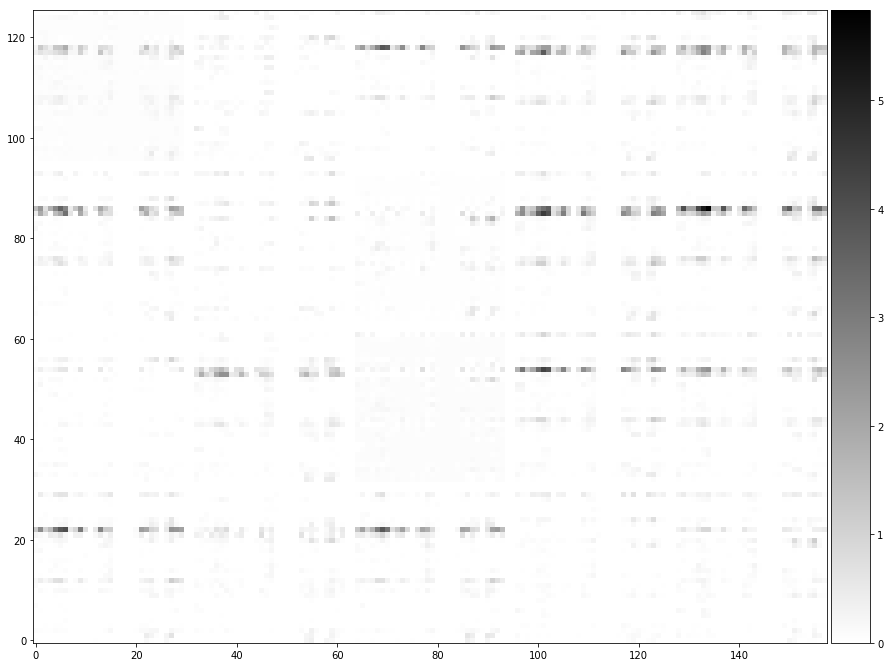

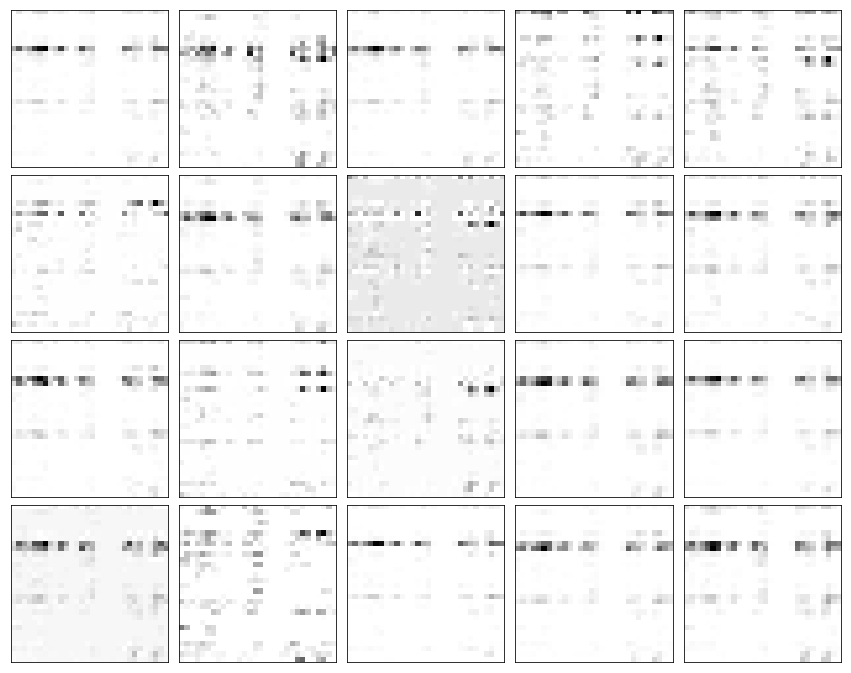

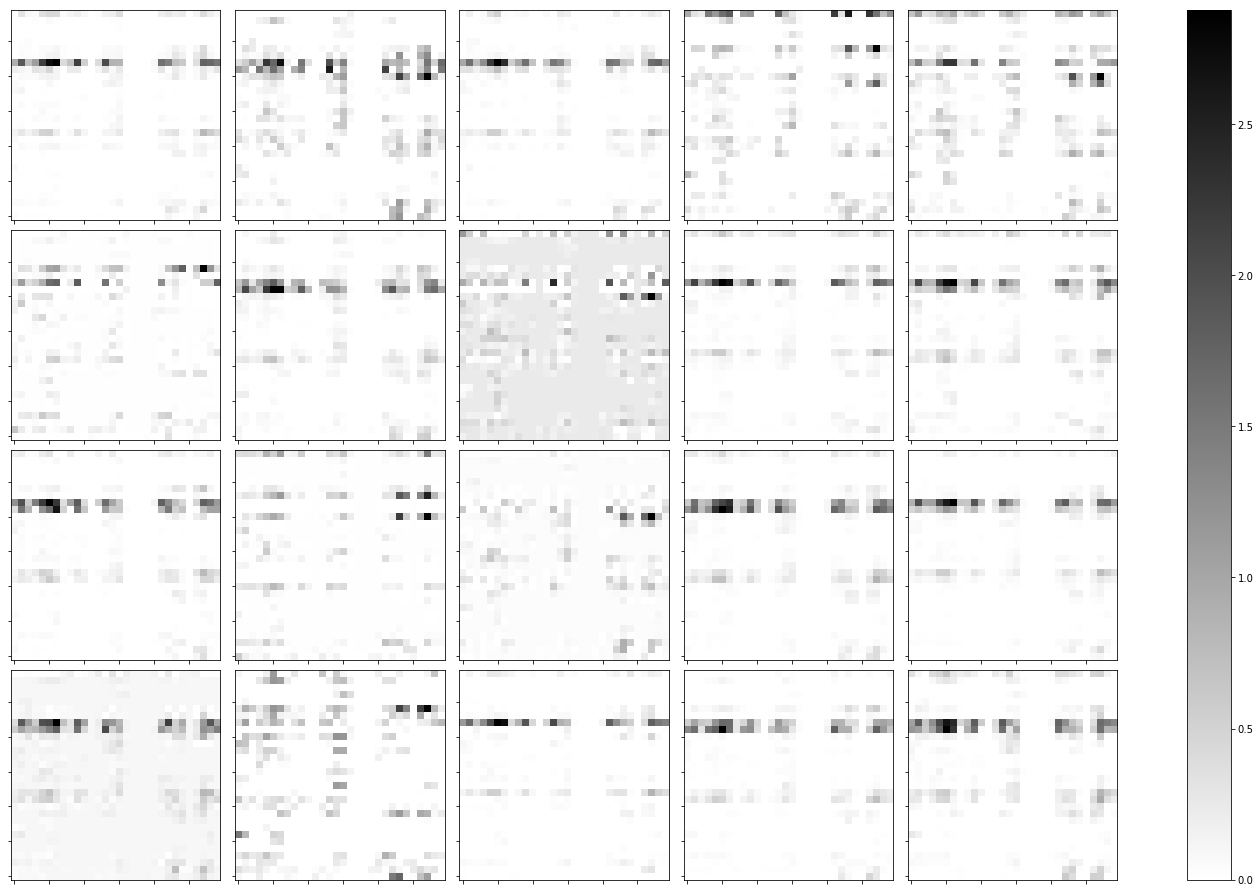

In [76]:
# Visualize the first layer of convolutions on an input image
X = x_train[i][0]
print(X)
print(y_train_true[i])
pl.figure(figsize=(15, 15))
nice_imshow(pl.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.binary)
pl.savefig(MODEL_NAME +  "_input_" + str(int(y_train_true[i])), bbox_inches='tight', pad_inches=1)
pl.show()

# Visualize convolution result (after activation)
def get_layer_output(layer, input_img, layer_name):
    convout_f = K.function(model.inputs, [layer.output])
    C = convout_f([input_img])
    C = np.squeeze(C)
    print(layer_name + " output shape : ", C.shape)
    C = np.transpose(C)
    C = np.swapaxes(C,0,1)
    print(layer_name + " output shape : ", C.shape)
    return C


C1 = get_layer_output(convout1, x_train[i:i+1], layer_name="convout1_" + str(int(y_train_true[i])))
mosaic_imshow(C1, 2, 5, cmap=cm.binary, border=2, layer_name="convout1_" + str(int(y_train_true[i])))
plotNNFilter(C1, 2, 5, cmap=cm.binary, layer_name="convout1_" + str(int(y_train_true[i])))
plotNNFilter2(C1, 2, 5, cmap=cm.binary, layer_name="convout1_" + str(int(y_train_true[i])))

C2 = get_layer_output(convout2, x_train[i:i+1], layer_name="convout2_" + str(int(y_train_true[i])))
mosaic_imshow(C2, 4, 5, cmap=cm.binary, border=2, layer_name="convout2_" + str(int(y_train_true[i])))
plotNNFilter(C2, 4, 5, cmap=cm.binary, layer_name="convout2_" + str(int(y_train_true[i])))
plotNNFilter2(C2, 4, 5, cmap=cm.binary, layer_name="convout2_" + str(int(y_train_true[i])))

W1 shape :  (10, 10, 10)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:861: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


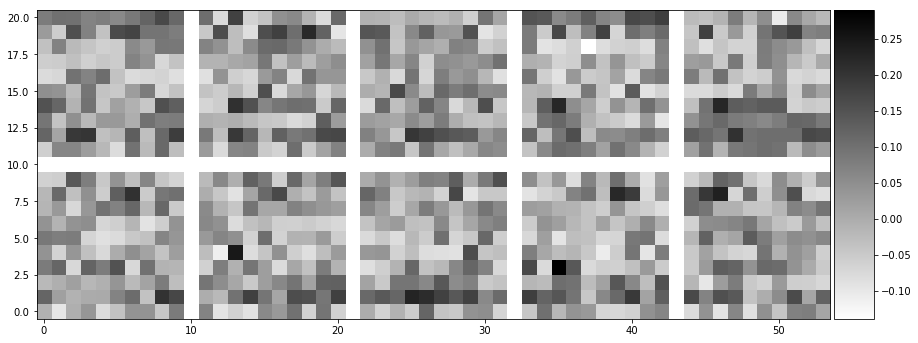

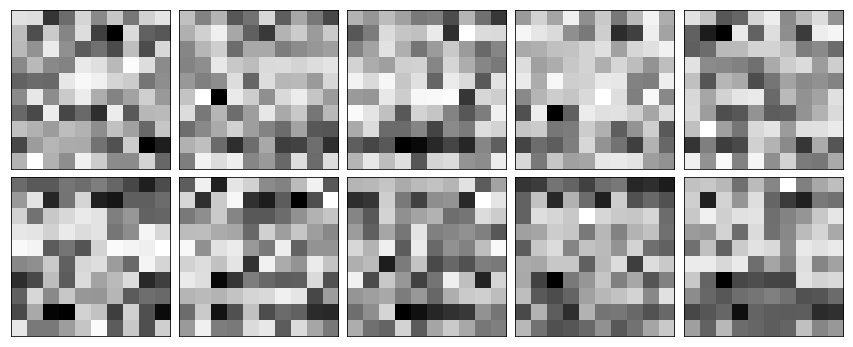

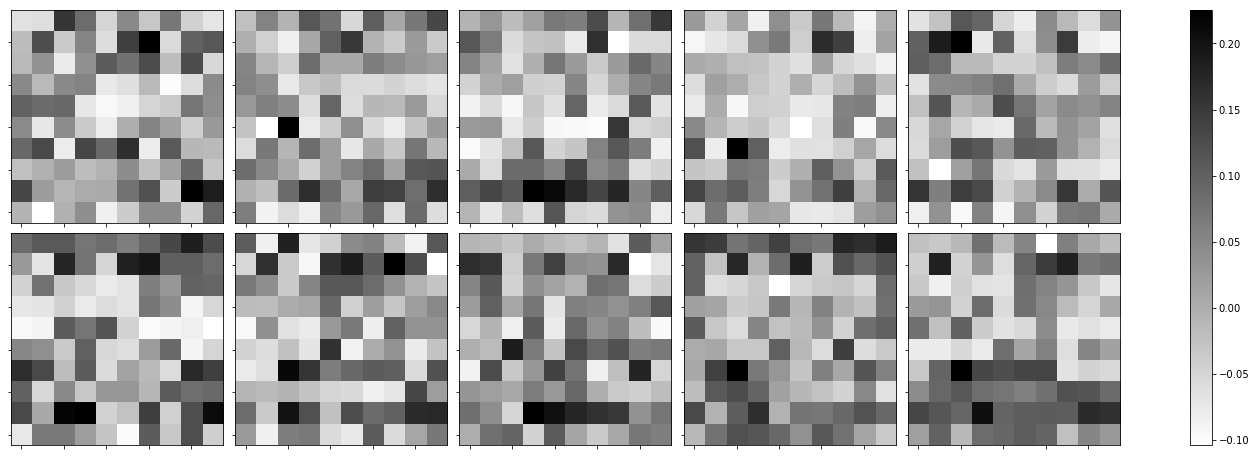

W2 shape :  (10, 10, 20)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:860: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


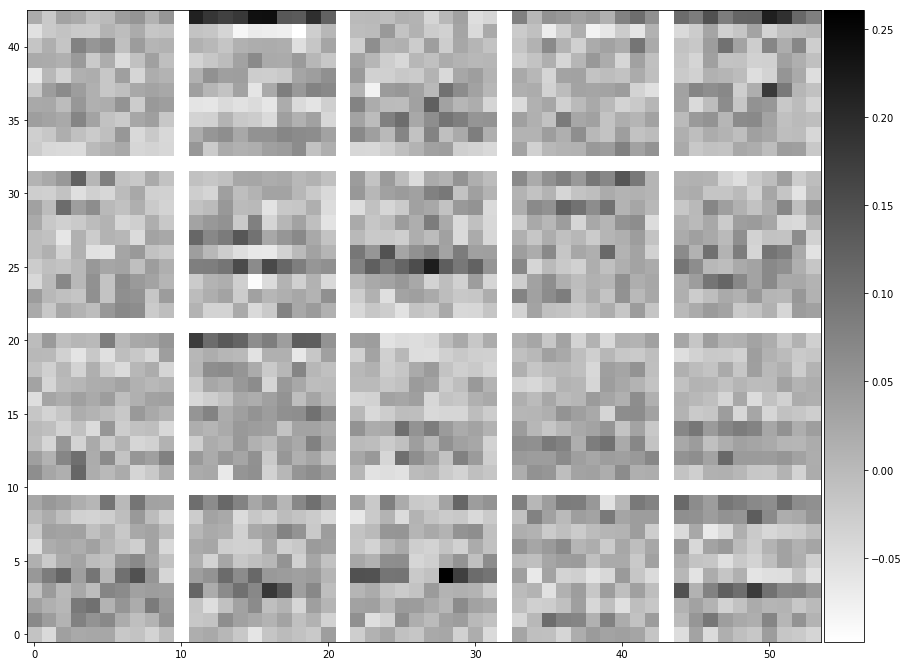

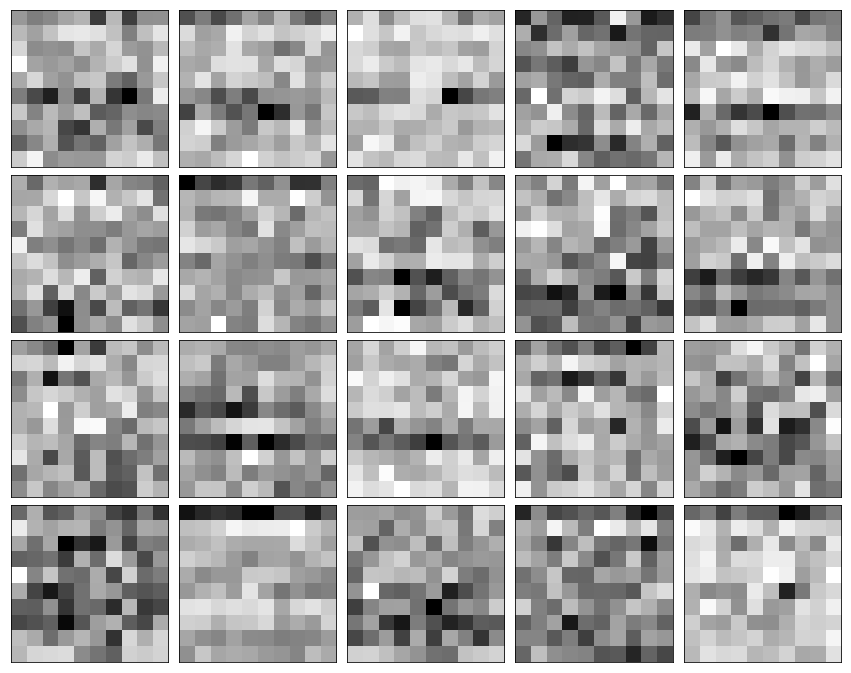

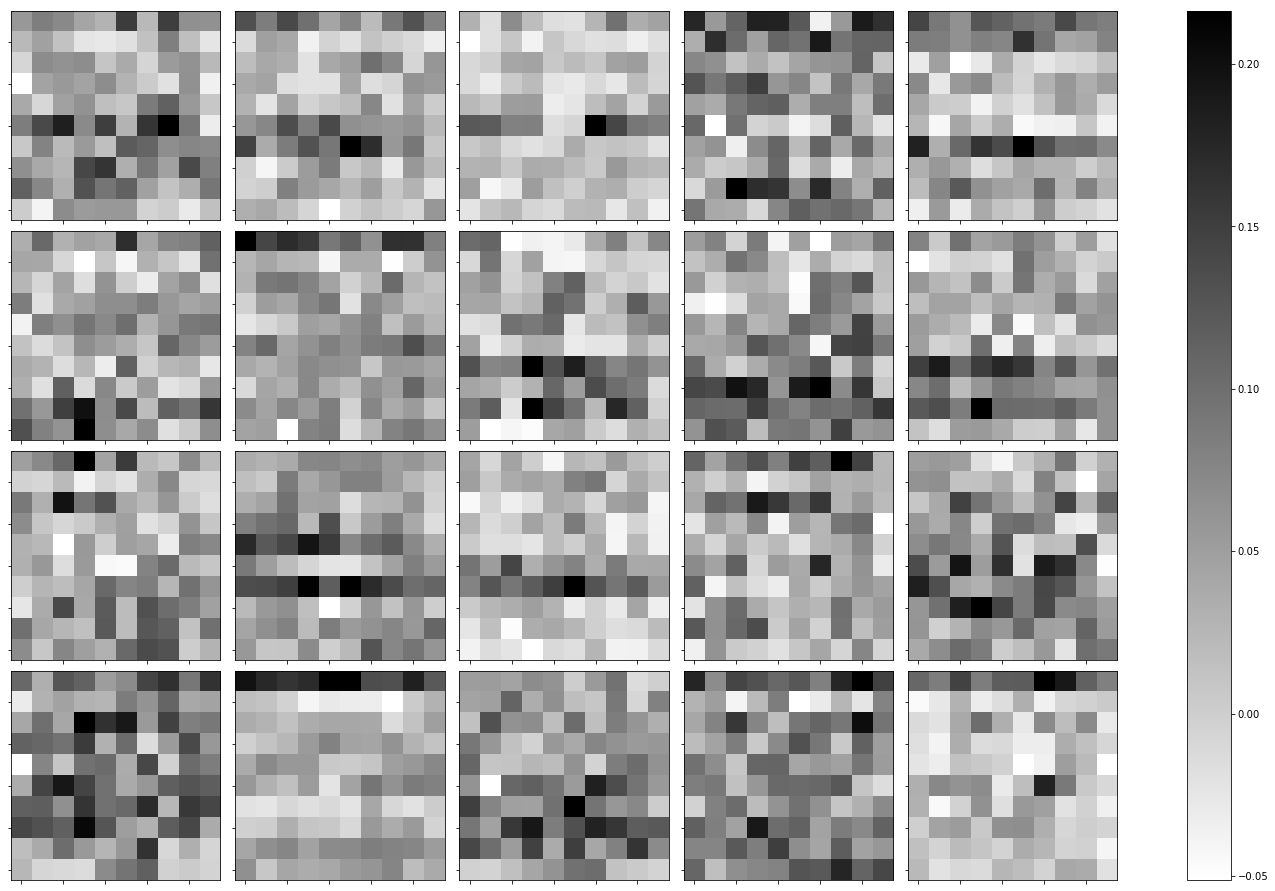

In [22]:
# Visualize weights
W1 = model.layers[0].get_weights()[0]
W1 = np.squeeze(W1)
# W1 = np.asarray(W1)
print("W1 shape : ", W1.shape)

mosaic_imshow(W1, 2, 5, cmap=cm.binary, border=1, layer_name="conv1_weights")
plotNNFilter(W1, 2, 5, cmap=cm.binary, layer_name="conv1_weights")
plotNNFilter2(W1, 2, 5, cmap=cm.binary, layer_name="conv1_weights")

# Visualize weights
W2 = model.layers[3].get_weights()[0][:,:,0,:]
W2 = np.asarray(W2)
print("W2 shape : ", W2.shape)

mosaic_imshow(W2, 4, 5, cmap=cm.binary, border=1, layer_name="conv2_weights")
plotNNFilter(W2, 4, 5, cmap=cm.binary, layer_name="conv2_weights")
plotNNFilter2(W2, 4, 5, cmap=cm.binary, layer_name="conv2_weights")


In [ ]:
y_val_true, y_val_prediction

for j in range(len(y_val_true)):
    if y_val_true[j] == 0 and y_val_prediction[j] == 1:
        print(j, sum(sum(sum(x_val[j]))))
#         pl.figure(figsize=(10, 10))
#         pl.title('input ' + str(j))
#         nice_imshow(pl.gca(), np.squeeze(x_val[j]), vmin=0, vmax=1, cmap=cm.binary)
#         pl.savefig(MODEL_NAME +  "_input", bbox_inches='tight', pad_inches=1)
#         pl.show()

### Import test data

In [79]:
x_test_vpn = np.load(PATH_PREFIX + "vpn_x_test.npy")
y_test_vpn_true = np.load(PATH_PREFIX + "vpn_y_test.npy")
x_test_tor = np.load(PATH_PREFIX + "tor_x_test.npy")
y_test_tor_true = np.load(PATH_PREFIX + "tor_y_test.npy")

y_test_vpn = np_utils.to_categorical(y_test_vpn_true, num_classes)
y_test_tor = np_utils.to_categorical(y_test_tor_true, num_classes)

print(x_test_vpn.shape, y_test_vpn.shape)
print(x_test_tor.shape, y_test_tor.shape)

(1124, 1, 1500, 1500) (1124, 5)
(2464, 1, 1500, 1500) (2464, 5)


### Evaluate model on test data

In [80]:
# model.load_weights(MODEL_NAME + '.hdf5')

score_val = model.evaluate(x_val, y_val, verbose=1)
print('Validation loss:', score_val[0])
print('Validaion accuracy:', score_val[1])
print('Validaion top_2_categorical_accuracy:', score_val[2])

score_vpn = model.evaluate(x_test_vpn, y_test_vpn, verbose=1)
print('VPN_Test loss:', score_vpn[0])
print('VPN_Test accuracy:', score_vpn[1])
print('VPN_Test top_2_categorical_accuracy:', score_vpn[2])

score_tor = model.evaluate(x_test_tor, y_test_tor, verbose=1)
print('TOR_Test loss:', score_tor[0])
print('TOR_Test accuracy:', score_tor[1])
print('TOR_Test top_2_categorical_accuracy:', score_tor[2])

314/314 [==============================] - 29s    
Validation loss: 0.336662959066
Validaion accuracy: 0.847133757962
Validaion top_2_categorical_accuracy: 0.993630573248
1124/1124 [==============================] - 102s   
VPN_Test loss: 4.94784528505
VPN_Test accuracy: 0.556939501779
VPN_Test top_2_categorical_accuracy: 0.965302491103
2464/2464 [==============================] - 224s   
TOR_Test loss: 5.39122196528
TOR_Test accuracy: 0.387581168831
TOR_Test top_2_categorical_accuracy: 0.735795454545


In [81]:
y_test_vpn_prediction = model.predict_classes(x_test_vpn, verbose=1)
y_test_tor_prediction = model.predict_classes(x_test_tor, verbose=1)

2464/2464 [==============================] - 242s   


Normalized confusion matrix
[[ 0.97  0.    0.03  0.    0.  ]
 [ 0.    0.99  0.    0.    0.01]
 [ 0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.26  0.74]
 [ 0.    0.    0.    0.08  0.92]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Normalized confusion matrix
[[ 0.99  0.    0.01  0.    0.  ]
 [ 0.    0.01  0.    0.    0.99]
 [ 0.01  0.01  0.57  0.27  0.14]
 [ 0.02  0.    0.1   0.65  0.22]
 [  nan   nan   nan   nan   nan]]
Normalized confusion matrix
[[ 0.    0.26  0.05  0.52  0.16]
 [ 0.    0.73  0.03  0.03  0.2 ]
 [ 0.1   0.48  0.38  0.01  0.03]
 [ 0.    0.02  0.    0.31  0.67]
 [ 0.01  0.09  0.1   0.24  0.55]]


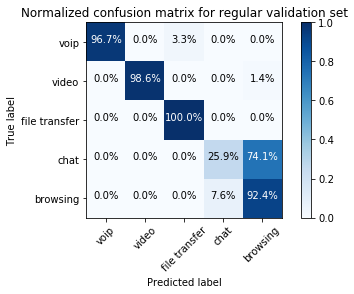

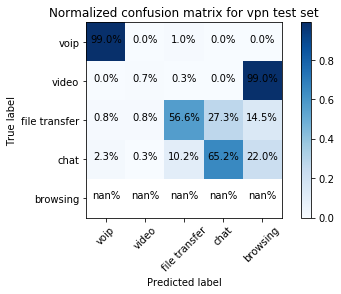

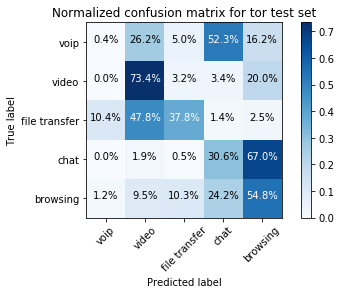

In [82]:
cnf_matrix_val = confusion_matrix(y_val_true, y_val_prediction)
cnf_matrix_vpn = confusion_matrix(y_test_vpn_true, y_test_vpn_prediction)
cnf_matrix_tor = confusion_matrix(y_test_tor_true, y_test_tor_prediction)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_val, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for regular validation set',
                      fname=MODEL_NAME + "_val_" + 'Normalized_confusion_matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_vpn, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for vpn test set',
                      fname=MODEL_NAME + "_test_vpn_" + 'Normalized_confusion_matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_tor, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for tor test set',
                      fname=MODEL_NAME + "_test_tor_" + 'Normalized_confusion_matrix')

plt.show()

### Save Model and weights

In [23]:
model_json = model.to_json()
with open(MODEL_NAME + '.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(MODEL_NAME + '.h5')
print("Save Model")

Save Model
